# Projet spark

## Première requète : les accidents de vélo 

Problématique : en quelles périodes de l'année trouvent on le plus d'accidents impliquant un vélo et dans quelles zones se situent-ils sur le territoire métropolitain ?

Cette première requête va tout d'abord représenter le nombre d'accidents impliquant un vélo par mois et ainsi identifier les périodes les plus à risques. Ensuite, dans un second temps, on représentera sur la carte de France ces accients pour nous permettre d'identifier quelle région de France est le plus à risque pour un cycliste pour différentes périodes de l'année.

### I. Importation et initialisation de spark

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import seaborn as sns

In [2]:
spark = SparkSession.builder.master("local").getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/18 11:28:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### II. Chemin et fonction

On définit les chemins menant aux différents fichiers décrivant les accidents. A noter que le $*$ à la fin de chaque nom de fichier va nous permettre d'importer à la suite tous les fichiers du type $usagers$ par exemple. Ainsi, quand on créera nos $rdd$ on aura importé toutes les années.

Problème: On importera également les 8 en-têtes à chaque fois. Il faudra donc les enlever et c'est le but de la fonction $recup$ ci-dessous.

In [3]:
path_usg="/users/2023/ds2/118000246/Documents/big data/projet2 spark/accidents/usagers_*.csv"
path_caract="/users/2023/ds2/118000246/Documents/big data/projet2 spark/accidents/caracteristiques_*.csv"
path_lieux="/users/2023/ds2/118000246/Documents/big data/projet2 spark/accidents/lieux_*.csv"
path_vehicule="/users/2023/ds2/118000246/Documents/big data/projet2 spark/accidents/vehicules_*.csv"

#### II.1 Explication et exemple

Une importation standard rend le résultat ci-dessous.

In [4]:
exemple=sc.textFile(path_usg)
exemple.take(3)

['Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh',
 '201100000001,1,1,3,1,5,21,0,0,0,1995,A01',
 '201100000001,1,1,1,1,5,11,0,0,0,1949,B02']

Le but est de retirer toutes les en-têtes, c'est pourquoi on applique le filtre : $ \text{ligne différent de "N"} $ avant de split les lignes.

In [5]:
exemple.filter(lambda l: l[0]!='N').map(lambda t: t.split(",")).take(3)

[['201100000001', '1', '1', '3', '1', '5', '21', '0', '0', '0', '1995', 'A01'],
 ['201100000001', '1', '1', '1', '1', '5', '11', '0', '0', '0', '1949', 'B02'],
 ['201100000002', '1', '1', '1', '1', '0', '11', '0', '0', '0', '1967', 'A01']]

#### II.2 La fonction

Telle est le but de la première ligne de la fonction. Ensuite, le reste permet de sélectionner à l'aide d'un $map$ les variables qui nous intéressent.

In [6]:
def recup(chemin,variable_a_retenir):
    lines=sc.textFile(chemin).filter(lambda l: l[0]!='N').map(lambda t: t.split(",")) # importation des fichiers, filtre les en-têtes puis on split
    
    if variable_a_retenir=="all": # si all est paasé en argument, alors on retourne directement toutes les variables sans se donner la peine de tout écrire
        return lines        
    else: 
        rdd=lines.map(lambda p: [p[variable] for variable in variable_a_retenir])
        return rdd

In [7]:
exemple=recup(path_usg,[0,3])
exemple.take(3)

[['201100000001', '3'], ['201100000001', '1'], ['201100000002', '1']]

### III. Les accidents de vélo

#### III.1 Préparation des données

On utilise la fonction $recup$ sur les fichiers $véhicules$ et en sélectionnant que les variables : $Num Acc \text{ et } catv$ la catégorie de véhicules. Avec un filtre, on ne retient que les accidents impliquant un vélo. Le map qui termine la ligne permet de ne prendre que la colonne des $Num Acc$ pour les rendre unique à la ligne suivante à l'aide d'un $distinct()$. Le map qui suit forme des couples clés-valeurs de la forme :

$$(NumAcc, \text{ l'année de l'accident})$$

In [8]:
acc_velo=recup(path_vehicule,[0,2]).filter(lambda l: l[1]=='01').map(lambda l: l[0]) # fonction recup sur les fichiers véhicules et des variables 0 et 2, filtre sur la var2 = "01" et map pour sélectionner la 1er colonne  
acc_velo_uniq=acc_velo.distinct().map(lambda l: (l,l[0:4])) # distinct pour rendre unique et map pour faire des couples clef-valeur

acc_velo_uniq.take(3)

[('201100000155', '2011'), ('201100000202', '2011'), ('201100000239', '2011')]

Pour avoir accès aux mois, Gps et coordonnées géographiques des accidents, on s'intéresse aux fichiers $caractéristiques$. A l'aide de la fonction $recup$ on sélectionne la variable : $NumAcc \text{, } mois \text{, } gps \text{, } lat \text{, } long$, et on filtre sur le territoire métropolitain ($gps=M$). Le map suivant forme des couples clés-valeurs de la forme:

$$(NumAcc \text{, } [mois \text{, } gps \text{, } lat \text{, } long] )$$

In [9]:
rdd_caract=recup(path_caract,[0,2,12,13,14]).filter(lambda l: l[2]=='M')
rdd_caract=rdd_caract.map(lambda l: (l[0],l[1:]))

rdd_caract.take(3)

[('201100000001', ['1', 'M', '5053589', '0295262']),
 ('201100000002', ['6', 'M', '5051652', '0293898']),
 ('201100000003', ['9', 'M', '5051080', '0290322'])]

Nos couples clés-valeurs sont créées, on va donc effectuer une jointure sur les $NumAcc$. On a donc un $rdd$ de la forme:

$$[\text{ } NumAcc \text{, } (\text{ }année \text{, } [mois \text{, } gps \text{, } lat \text{, } long]\text{ })\text{ }]$$

Le map suivant permet de prendre uniquement les valeurs de chaque clés.

In [10]:
velo=acc_velo_uniq.join(rdd_caract).map(lambda l: l[1]) # jointure du rdd des caractéristiques sur celui des accidents de vélo rendu unique
velo.take(3)

[('2011', ['1', 'M', '5066700', '0203100']),
 ('2011', ['6', 'M', '0000000', '0000000']),
 ('2011', ['12', 'M', '0000000', '0000000'])]

#### III.2 Choix de l'année et des mois

La fonction suivante va nous permettre par la suite de filtrer notre $rdd$ en fonction des années et des mois saisi en argument sous forme de liste de string.

In [11]:
def choix_date(rdd,annees,periode):
    rdd_filtre_annee=rdd.filter(lambda l: l[0] in annees).map(lambda l: l[1]) # filtre sur les années + map pour ne sélectionner par la suite que : [mois, gps, lat, long]
    rdd_periode=rdd_filtre_annee.filter(lambda l: l[0] in periode) # filtre sur les mois

    rdd=rdd_periode.groupBy(lambda l: l[0]).mapValues(len).sortByKey() # Groupby sur les mois pour compter le nb d'accidents sur chaque mois. mapvalues pour afficher les valeurs
    
    df_spark=rdd.toDF() # converits le rdd en dataframe spark
    df_spark=df_spark.withColumnRenamed('_1','mois') # renomme la 1er colonne
    df_spark=df_spark.withColumnRenamed('_2','accident') # renomme la 2e colonnes
    df_pandas=df_spark.toPandas() # convertis le dataframe spark en dataframe pandas

    df_pandas.accident=[valeur/len(annees) for valeur in list(df_pandas.accident)] # on divise chaque valeur des mois par le nombre d'année qu'on a pris pour faire la moyenne

    return df_pandas

On appelle la fonction sur le rdd $velo$ créée précédemment sur toutes les années et tous les mois. 

<AxesSubplot:xlabel='mois', ylabel='accident'>

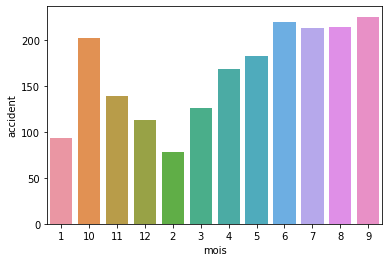

In [12]:
annees=[str(2011 +i) for i in range(8)] # liste de toutes les années
mois=[str(i) for i in range(1,13)] #liste de tous les mois

df=choix_date(velo,annees,mois)

sns.barplot(x="mois",y="accident",data=df) # on plot un histogramme avec seaborn

On peut voir que c'est durant la période d'été qu'on trouve le plus grand nombre d'accident, c'est-à-dire aux mois de juin, Juillet, Août, Septembre. Au printemps (mars, avril et mai), on constate une croissance du nombre d'accidents probablement lié à la reprise du vélo suite à l'arrivée des beaux jours et aux journées qui se rallongent. On constate l'inverse en automne (Octobre, Novembre, Décembre) où l'on remarque une décroissance des accidents, probablement lié à la baisse progressive des activités cyclistes à cause de l'arrivée du froid, des pluies et des journées qui se raccourcissent. Puis en hiver où l'on constate les niveaux les plus bas.  

#### III.3 Représentation cartographié:

Pour cela, on va utiliser le package $geopandas$. On a été cherché sur internet les coordonnées de la France au niveau départementale au format geojson. Le principe est de créer un géodataframe constitué de point former par la latitude et la longitude des accidents. Ainsi, on projettera tous ces points sur la carte de France.

In [13]:
path_fr=r"/users/2023/ds2/118000246/Documents/big data/projet2 spark/departements.geojson"

Cette fonction est comme $choix \text{ } annee$, elle permet de choisir les années et les mois sur lesquelles filtré notre $rdd$. Après avoir filtrer les années et les mois, on s'intéresse aux latitudes et longitudes des accidents. Cependant, en regardant les fichiers csv, on remarque beaucoup de données manquantes. Quand une coordonnée n'est pas renseigné, soit il y a un 0, soit il n'y a rien tout simplement. On supprime donc ces données à l'aide de deux filtres:

- Le premier permet de conserver toutes les valeurs différentes d'une espace vide 

- Le second de ne conserver que les valeurs supérieures à 30 en valeurs absolues (30 est une minoration large des latitudes de France). 

A noter qu'on divise par 100000 car les données présentes dans les fichiers csv sont des entiers dont la virgule a été oublié. En faisant quelques recherches sur internet sur les limites des coordonnées gps de la France et en constatant que les données étaient toujours des str à 7 éléments, on en a conclu que l'on devait diviser par 100000 et en constatant les résultats plus bas, on pourrait penser que cette correction est juste.

Ensuite, on crée deux rdd, un pour la latitude et un pour la longitude. Puis on génère une liste de points geographiques à l'aide du module $shapely$ avec laquelle on génère un géodataframe de ces points. Un geodataframe se créer à partir d'une liste d'éléments géométrique. C'est l'objectif de l'argument $geometry$ de reconnaitre les éléments géométriques de la liste qu'on passe en argument. En l'occurrence, ici, ce sont des points.

In [14]:
def choix_date_gps(rdd,annees,mois):
    rdd_filtre=rdd.filter(lambda l: l[0] in annees).map(lambda l: l[1]) # filtre sur les années 
    rdd_saison=rdd_filtre.filter(lambda l: l[0] in mois).filter(lambda l: l[2]!='').filter(lambda l: abs(int(l[2])/100000)>30) # filtre sur les mois, filtre pour enlever les espaces vides, puis filtre pour enlever les 0
    rdd_lat=rdd_saison.map(lambda l: l[2]).map(lambda l: int(l)/100000).collect() # rdd des latitudes
    rdd_long=rdd_saison.map(lambda l: l[3]).map(lambda l: int(l)/100000).collect() # rdd des longitudes

    geometry = [Point(xy) for xy in zip(rdd_long,rdd_lat)] # zip de 2 listes renvoie une liste : [(a1,b1), (a2,b2), ...]
    geo_df = gpd.GeoDataFrame(geometry = geometry) # création du geodataframe, en argument on indique 
    
    return geo_df

##### Création des différentes saisons expliqué plus haut

In [15]:
ete=["6","7","8","9"]
hiver=["1","2","3"]
automne=["10","11","12"]
printemps=["4","5","6"]

all_annee=[str(2011+i) for i in range(8)]

##### Représentation 

On se propose ici de ne représenter que les accidents survenus en été et en hiver pour éviter de trop surcharger la carte. Les points en rouge représentent les accidents en été et en jaunes les accidents en hiver. 

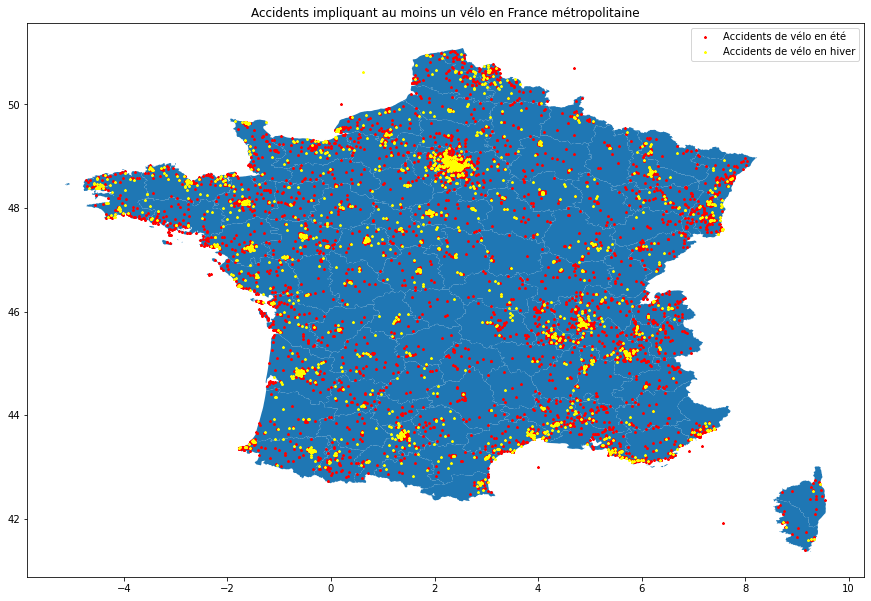

In [16]:
geo_df_ete=choix_date_gps(velo,all_annee,ete) # geodataframe ete
geo_df_hiver=choix_date_gps(velo,all_annee,hiver) # geodataframe hiver
#geo_df_automne=choix_date_gps(velo,all_annee,automne)
#geo_df_printemps=choix_date_gps(velo,all_annee,printemps)

df_france=gpd.read_file(path_fr) # importation du fichier geojson de la france
geo_df_france = gpd.GeoDataFrame(geometry = list(df_france.geometry)) # création d'un geodatframe avec comme argument en geometry la liste des éléments du geojson qui sont des polygones (les départements)

fig,ax = plt.subplots(figsize = (15,15))
ax.set_title("Accidents impliquant au moins un vélo en France métropolitaine")

geo_df_france.plot(ax=ax) # plot des départements sur l'axe initialiser ci-dessus

g_ete = geo_df_ete.plot(ax = ax, markersize = 5, color = 'red',marker = '*',label = 'Accidents de vélo en été') # plot des points été
g_hiver = geo_df_hiver.plot(ax = ax, markersize = 5, color = 'yellow',marker = '*',label = 'Accidents de vélo en hiver') # plot des points hiver
#g_printemps = geo_df_printemps.plot(ax = ax, markersize = 5, color = 'black',marker = '*',label = 'Accidents de vélo en été')
#g_automne = geo_df_automne.plot(ax = ax, markersize = 5, color = 'green',marker = '*',label = 'Accidents de vélo en été')

plt.legend()
plt.show()

On peut donc constater que les régions de France comportant le plus d'accidents sont les chaines montagneuses des alpes et des Vosges (région où les cyclistes partent le plus souvent en vacances). Il y a aussi les côtes Vendéennes, Bretonnes et Méditérannéenne, destination principale des touristes à vélo. Et bien sur, il y a la région parisienne qui concentre beaucoup d'accidents étant donnés la densité de la population là-bas.

Avec des recherches, on sait que les principales villes comportant le plus de cycliste (touriste, vélotaf, cyclosportif,...) son Grenoble, Strasbourg, Rennes, Nantes, Paris et Lille. En regardant la carte, on peut constater que c'est dans ces villes que se concentrent le plus d'accidents également à ajouter les côtes Vendéennes, Bretonnes et méditérannéenne.

## Requete 2: représentation des accidents mortelle sur le territoire métropolitain

Cette seconde requête a pour but de déterminer en quels mois constatent on le plus d'accidents mortels et de les cartographier pour identifier dans quelle région on en trouve le plus.

### I. Accidents mortelles

#### I.1 Préparation des données

A l'aide de la fonction $recup$, on prend tous les fichiers $usagers$ avec les variables: $NumAcc \text{ et } grav$. On filtre ensuite sur la gravité $tuée$ des usagers et on map pour n'avoir que les $NumAcc$ puisqu'il faut un rdd que d'une seule colonne pour pouvoir appliquer la fonction $distinct()$ pour les rendre unique. Le map suivant créer comme précédemment, des couples clés-valeurs :

$$(NumAcc, \text{ } annee)$$

In [17]:
rdd_usg=recup(path_usg,[0,3]).filter(lambda l: l[1]=='2').map(lambda l: l[0])
acc_mort=rdd_usg.distinct().map(lambda l: (l,l[0:4]))

rdd=acc_mort.join(rdd_caract).map(lambda l: l[1])
rdd.take(3)   

[('2011', ['12', 'M', '5029165', '0315020']),
 ('2011', ['8', 'M', '0000000', '0000000']),
 ('2011', ['10', 'M', '0000000', '0000000'])]

#### I.2 Création du rdd et histogramme

Puis, on $join$ ce rdd avec le rdd des $caractéristiques$ définit dans la première requête. Le map permet de ne prendre en compte que les valeurs comme suit:

In [18]:
rdd=acc_mort.join(rdd_caract).map(lambda l: l[1])
rdd.take(3)  

[('2011', ['12', 'M', '5029165', '0315020']),
 ('2011', ['8', 'M', '0000000', '0000000']),
 ('2011', ['10', 'M', '0000000', '0000000'])]

On appelle la fonction $choix \text{ } date$ qu'on applique au rdd des accidents mortels pour avoir le choix sur les années et les mois que l'on souhaite. Puis on représente par un histogramme.

<AxesSubplot:xlabel='mois', ylabel='accident'>

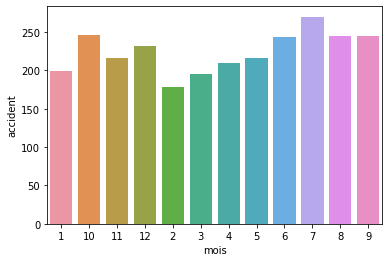

In [19]:
df_acc_mort=choix_date(rdd,annees,mois)
sns.barplot(x="mois",y="accident",data=df_acc_mort)

On peut voir qu'en moyenne c'est au mois d'octobre et les mois d'été (Juin, Juillet, Août, Septembre) qu'on constate le plus d'accident mortel. Pour l'été on pourrait expliquer cela par les départs massifs en vacances et pour octobre, le changement horaire, la nuit tombant plus tôt, l'arrivée des pluies et du brouillard.

### Représentation cartographié:

On va représenter pour l'exemple le mois de juillet qui comporte le plus d'accident mortel avec celui d'octobre.

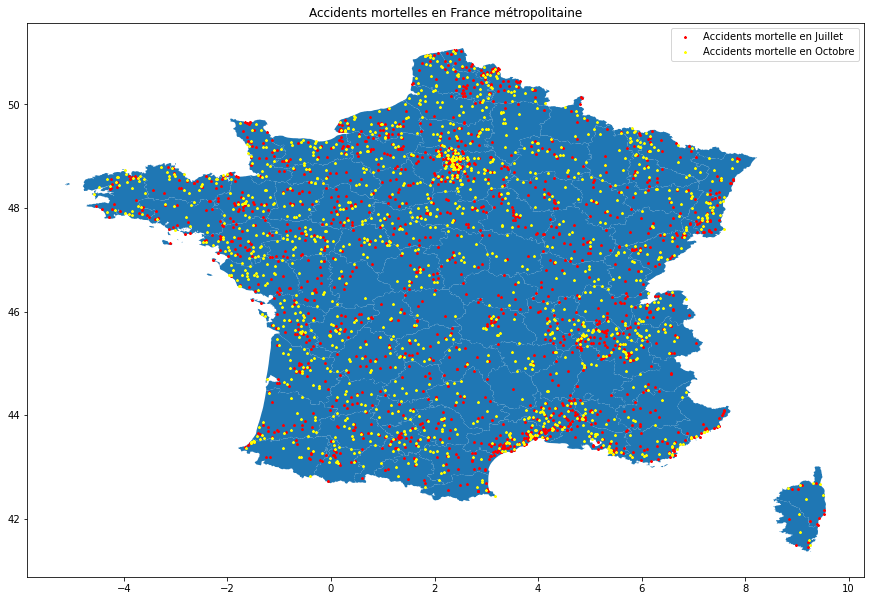

In [20]:
juillet=choix_date_gps(rdd,annees,["7"])
octobre=choix_date_gps(rdd,annees,["10"])

df_france=gpd.read_file(path_fr)
geo_df_france = gpd.GeoDataFrame(geometry = list(df_france.geometry))

fig,ax = plt.subplots(figsize = (15,15))

ax.set_title("Accidents mortelles en France métropolitaine")
geo_df_france.plot(ax=ax)

g_juillet = juillet.plot(ax = ax, markersize = 5, color = 'red',marker = '*',label = 'Accidents mortelle en Juillet')
g_octobre= octobre.plot(ax = ax, markersize = 5, color = 'yellow',marker = '*',label = 'Accidents mortelle en Octobre')

plt.legend()
plt.show()

On peut voir que les régions les plus à risque sont les zones les plus peuplées. En effet, on retrouve Paris, Lille, la zone regroupant des grosses villes comme Lyon, Grenoble et St Etienne, ainsi que la côte méditerranéenne.